In [1]:
include("../../src/utilities.jl")
include("../../src/model_with_ribosomes_functions.jl")
include("../../src/canonical_two_stage_model_with_division_functions.jl")
using Catalyst, DifferentialEquations, PyPlot, Statistics

In [2]:
function simulate_cycle(model, p, t0, t_fin, T, species_0)
    tstops = [t0+T:T:t_fin;]
    
    prob = DiscreteProblem(model, species_0, (t0,t_fin), p)
    jump_prob = JumpProblem(model, prob, Direct(), save_positions=(false,false))
        
    condition(u,t,integrator) = t%T==0.0
    affect!(integrator) = integrator.u = Utilities.partition_species(integrator.u)
    cb = DiscreteCallback(condition,affect!)
    
    sol = solve(jump_prob, SSAStepper(), saveat=0.01, callback=cb, tstops=tstops)
    return sol
end

function simulate_stochastic_cycle(model, p, t0, t_fin, T, species_0, N)
   prob = DiscreteProblem(
        model,
        species_0,
        (t0,t_fin),
        p
    )
    jump_prob = JumpProblem(model, prob, Direct())
    
    function affect!(integrator)
        integrator.u = Utilities.partition_species(integrator.u)
        integrator.u[length(integrator.u)] = 0
    end
        
    condition(u,t,integrator) = u[length(u)]==N
    cb = DiscreteCallback(condition,affect!)
    sol = solve(jump_prob, SSAStepper(), callback=cb)
    pop!(sol.u)
    pop!(sol.t)
    return sol
end

function beta_3_exact(beta, gamma, rho, T)
    return (3*beta *gamma *(6 *gamma ^2*T^2*
   exp(gamma  *T)-3 *gamma ^2 *T^2-4 *gamma *T*
   exp(gamma*T)+2 *gamma *T+2*exp(gamma *
   T)-2))/(rho*(26 *gamma ^3 *T^3*
   exp(gamma*T)-13 *gamma ^3 *T^3-12 *gamma ^2*
   T^2* exp(gamma  *T)+12 *gamma ^2 *T^2-6 *gamma* 
   T *exp(gamma * T)-6 *gamma  *T+12 *exp(gamma* 
   T)-12))
end

beta_3_exact (generic function with 1 method)

In [3]:
sc2s = @reaction_network begin
        alpha,  0-->m
        beta, m-->p + m
        gamma,  m-->0
        delta, p-->0
end alpha beta gamma delta

Model ##ReactionSystem#291 with 4 equations
States (2):
  m(t)
  p(t)
Parameters (4):
  alpha
  beta
  gamma
  delta

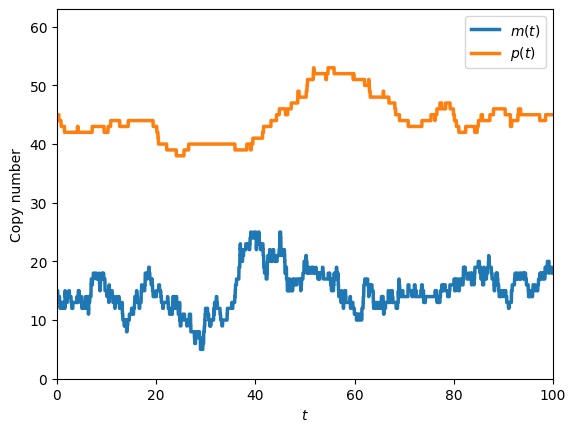

In [15]:
alph = 3.0
beta = 0.03
gamma = 0.2
delta = 0.01
T=100.5


sol = simulate_cycle(sc2s, [alph, beta, gamma, delta], 0.0, 100.0, T,
        [
            round(alph/gamma),
            round(alph*beta/(gamma*delta))
        ]
    )
    
t = sol.t
m = map(x -> x[1], sol.u)
p = map(x -> x[2], sol.u)
plot(t, m, label=L"m(t)", linewidth=2.5)
plot(t, p, label=L"p(t)", linewidth=2.5)
xlabel(L"t")
ylabel("Copy number")
legend()
ylim(0,maximum(p)+10)
xlim(0,100)
savefig("../../data/trajectories/model_I.svg")

In [16]:
c2s = @reaction_network begin
        alpha,  0-->m
        beta, m-->p + m
        gamma,  m-->0
    end alpha beta gamma

Model ##ReactionSystem#718 with 3 equations
States (2):
  m(t)
  p(t)
Parameters (3):
  alpha
  beta
  gamma

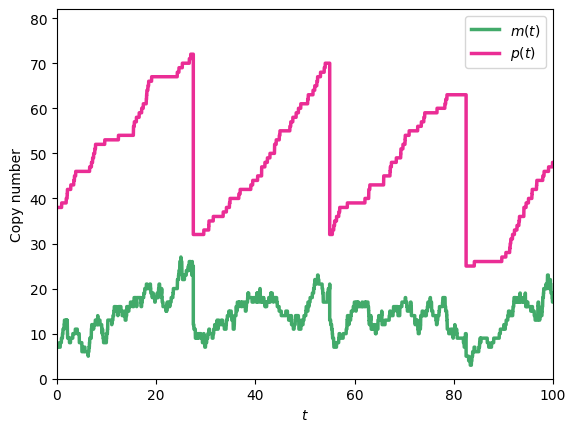

In [41]:
alph = 3.0
beta = 0.1
gamma = 0.2
T=27.5


sol = simulate_cycle(c2s, [alph, beta, gamma], 0.0, 100.0, T,
        [
            round(CanonicalTwoStageModel.mrna(alph, gamma, T, 0)),
            round(CanonicalTwoStageModel.approximate_protein_mean(alph, beta, gamma, T, 0))
        ]
    )
    
    t = sol.t
m = map(x -> x[1], sol.u)
p = map(x -> x[2], sol.u)
plot(t, m, label=L"m(t)", linewidth=2.5, color="#008d36bd")
plot(t, p, label=L"p(t)", linewidth=2.5, color="#e6007ed2")
xlabel(L"t")
ylabel("Copy number")
legend()
ylim(0,maximum(p)+10)
xlim(0,100)
savefig("../../data/trajectories/model_II.svg")

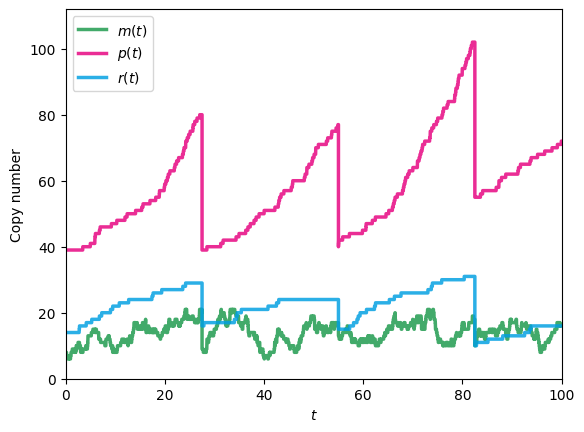

In [39]:
mwr = @reaction_network begin
    alpha,  0-->m
    beta, m + r-->p + m + r
    gamma,  m-->0
    rho, 0-->r
end alpha beta gamma rho

alph = 3.0
gamma = 0.2
rho = 0.5
T=27.5
beta = beta_3_exact(0.1, gamma, rho, T)


sol = simulate_cycle(mwr, [alph, beta, gamma, rho], 0.0, 100.0, T,
        [
            round(ModelWithRibosomes.mrna(alph, gamma, T, 0)),
            round(ModelWithRibosomes.r(rho, T, 0)),
            round(ModelWithRibosomes.p(alph, beta, gamma, rho, T, 0)),
        ]
    )

t = sol.t
m = map(x -> x[1], sol.u)
r = map(x -> x[2], sol.u)
p = map(x -> x[3], sol.u)
plot(t, m, label=L"m(t)", linewidth=2.5, color="#008d36bd")
plot(t, p, label=L"p(t)", linewidth=2.5, color="#e6007ed2")
plot(t, r, label=L"r(t)", linewidth=2.5, color="#009fe2d4")
xlabel(L"t")
ylabel("Copy number")
legend()
ylim(0,maximum(p)+10)
xlim(0,100)
savefig("../../data/trajectories/model_III.svg")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


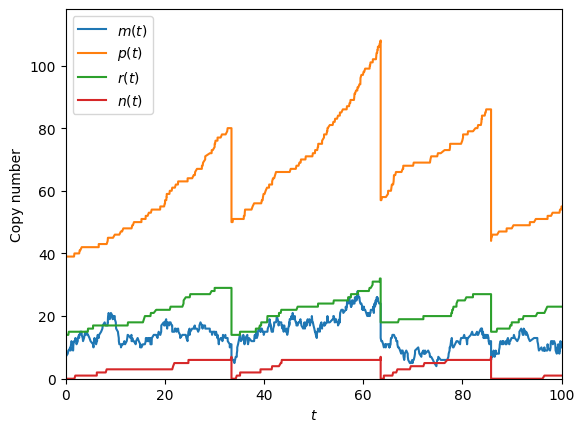

In [8]:
slm = @reaction_network begin
    alpha,  0-->m
    beta, m + r-->p + m + r
    gamma,  m-->0
    rho, 0-->r
    k, 0-->n
end alpha beta gamma rho k

alph = 3.0
gamma = 0.2
rho = 0.5
T=27.5
N = 7
beta = beta_3_exact(0.1, gamma, rho, T)
k = N/T

sol = simulate_stochastic_cycle(slm, [alph, beta, gamma, rho, k], 0., 100., T,
    [
        round(ModelWithRibosomes.mrna(alph, gamma, T, 0)),
        round(ModelWithRibosomes.r(rho, T, 0)),
        round(ModelWithRibosomes.p(alph, beta, gamma, rho, T, 0)),
        0
    ],
    N)

t = sol.t
m = map(x -> x[1], sol.u)
r = map(x -> x[2], sol.u)
p = map(x -> x[3], sol.u)
n = map(x -> x[4], sol.u)
plot(t, m, label=L"m(t)")
plot(t, p, label=L"p(t)")
plot(t, r, label=L"r(t)")
plot(t, n, label=L"n(t)", color="#d62728")
xlabel(L"t")
ylabel("Copy number")
legend()
ylim(0,maximum(p)+10)
xlim(0,100)
savefig("../../data/trajectories/model_V.eps")

In [9]:
slc2sm = @reaction_network begin
    alpha,  0-->m
    beta, m -->p + m
    gamma,  m-->0
    k, 0-->n
end alpha beta gamma k

Model ##ReactionSystem#295 with 4 equations
States (3):
  m(t)
  p(t)
  n(t)
Parameters (4):
  alpha
  beta
  gamma
  k

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


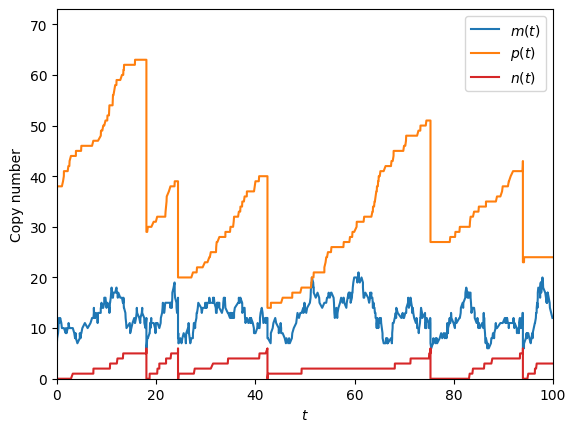

In [10]:
beta = 0.1
alph = 3.0
gamma = 0.2
T=27.5
N = 6
T=27.5
k = N/T

sol = simulate_stochastic_cycle(slc2sm, [alph, beta, gamma, k], 0., 100., T,
    [
        round(CanonicalTwoStageModel.mrna(alph, gamma, T, 0)),
        round(CanonicalTwoStageModel.approximate_protein_mean(alph, beta, gamma, T, 0)),
        0
    ],
    N)


t = sol.t
m = map(x -> x[1], sol.u)
p = map(x -> x[2], sol.u)
n = map(x -> x[3], sol.u)
plot(t, m, label=L"m(t)")
plot(t, p, label=L"p(t)")
plot(t, n, label=L"n(t)", color="#d62728")
xlabel(L"t")
ylabel("Copy number")
legend()
ylim(0,maximum(p)+10)
xlim(0,100)
savefig("../../data/trajectories/model_IV.eps")

## Replication

In [11]:
using DiffEqJump
alph = 3.0
gamma = 0.2
rho = 0.5
T=27.5
beta = beta_3_exact(0.1, gamma, rho, T)
N = 7
k = N/T

n = 4 # point of replication
p = (alph, gamma, beta, rho, k)

rate1(u,p,t) = u[4] > n ? 2 * alph : alph
function affect1!(integrator)
  integrator.u[1] += 1         # m -> m + 1
end
jump = VariableRateJump(rate1,affect1!)

rate2(u,p,t) = gamma * u[1]
function affect2!(integrator)
  integrator.u[1] -= 1         # m -> m + 1
end
jump2 = ConstantRateJump(rate2,affect2!)

rate3(u,p,t) = beta * u[1] * u[3]
function affect3!(integrator)
    integrator.u[2] += 1   # p -> p + 1
end
jump3 = ConstantRateJump(rate3, affect3!)
    
rate4(u,p,t) = rho
function affect4!(integrator)
    integrator.u[3] +=1
end
jump4=ConstantRateJump(rate4, affect4!)

rate5(u,p,t) = k
function affect5!(integrator)   # n -> n + 1
    integrator.u[4] += 1
end
jump5 = ConstantRateJump(rate5, affect5!)

function condition(u,t,integrator) # Event when event_f(u,t) == 0
    u[4] >= N
end

function affect!(integrator)
    partition = Utilities.partition_species(integrator.u[1:3])
    integrator.u[1] = partition[1]
    integrator.u[2] = partition[2]
    integrator.u[3] = partition[3]
    integrator.u[4] = 0
end

clb = DiscreteCallback(condition, affect!)

DiscreteCallback{typeof(condition), typeof(affect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}(condition, affect!, SciMLBase.INITIALIZE_DEFAULT, SciMLBase.FINALIZE_DEFAULT, Bool[1, 1])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


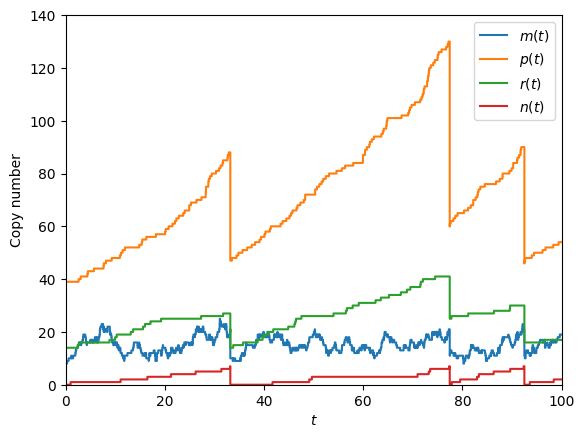

In [12]:
tspan = (0.0,100.0)
function f(du,u,p,t)
  du[5] = 0
end
u₀   = [
        round(ModelWithRibosomes.mrna(alph, gamma, T, 0)),
        round(ModelWithRibosomes.p(alph, beta, gamma, rho, T, 0)),
        round(ModelWithRibosomes.r(rho, T, 0)),
        0,
        0
    ]
prob = ODEProblem(f,u₀,tspan,p)
jump_prob = JumpProblem(prob,Direct(),jump,jump2,jump3, jump4, jump5)
sol = solve(jump_prob,Tsit5(), callback=clb)
    
t = sol.t
m = map(x -> x[1], sol.u)
p = map(x -> x[2], sol.u)
r = map(x -> x[3], sol.u)

n = map(x -> x[4], sol.u)
plot(t, m, label=L"m(t)")
plot(t, p, label=L"p(t)")
plot(t, r, label=L"r(t)")
plot(t, n, label=L"n(t)")
xlabel(L"t")
ylabel("Copy number")
legend()
ylim(0,maximum(p)+10)
xlim(0,100)
savefig("../../data/trajectories/model_VI.eps")